In [9]:
!pip install mxnet-cu101

In [10]:
import os

import mxnet as mx
import numpy as np
import torch
from mxnet import gluon
from torchvision.utils import save_image
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# sample coords contains a sample of coordinates for red and blue
df = pd.read_csv('sample_coords.csv', header=None)
df.columns=['x1','y1', 'x2','y2']
print(df.shape)
x_bounds = [min(min(df.x1), min(df.x2)) , max(max(df.x1), max(df.x2))]
y_bounds = [min(min(df.y1), min(df.y2)) , max(max(df.y1), max(df.y2))]
print(x_bounds)
print(y_bounds)
df.head()

(2307, 4)
[-120.0, 62.0]
[-120.0, 118.5]


,x1,y1,x2,y2
0,-57.714286,80.142857,-62.125000,-83.500000
1,-59.333333,59.833333,-63.250000,-62.125000
2,-66.200000,42.000000,-65.100000,-46.200000
3,-59.333333,31.000000,-64.142857,-29.428571
4,-60.833333,14.166667,-59.444444,-13.000000


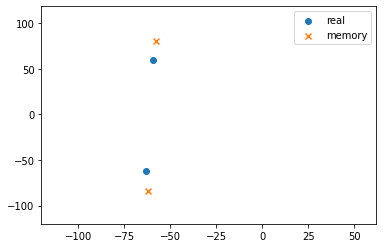

In [130]:
def plot_coords(real_coords, memory_coords, save_as=None):  
  plt.figure()
  x = [real_coords[0], real_coords[2]]
  y = [real_coords[1], real_coords[3]]
  plt.scatter(x, y, label='real')
  x = [memory_coords[0], memory_coords[2]]
  y = [memory_coords[1], memory_coords[3]]
  plt.scatter(x, y, label='memory', marker='x')

  plt.xlim(x_bounds)
  plt.ylim(y_bounds)
  plt.legend()
  
  if save_as:
    plt.savefig(save_as)
    plt.close()
# test plot function
plot_coords(df.iloc[1], df.iloc[0])

In [125]:
class autoencoder(gluon.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Dense(4, in_units = 4,  activation='relu'))
                self.encoder.add(gluon.nn.Dense(2))

            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(2, in_units =2, activation='relu'))
                self.decoder.add(gluon.nn.Dense(4))

    def encode(self, x):
      return self.encoder(x)

    def decode(self, x):
      return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [126]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [127]:
num_epochs = 200
batch_size = 128
learning_rate = 1e-3
ctx = mx.cpu()

In [128]:
# convert dataframe to gluon dataset
arr = df.to_numpy(dtype=np.float32)
dataset = mx.gluon.data.dataset.ArrayDataset(arr)

dataloader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [132]:
model = autoencoder()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()

optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    for data in dataloader:
        with mx.autograd.record():
            output = model(data)
            loss = criterion(output, data)
        loss.backward()
        optimizer.step(batch_size)
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += batch_size
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))
    if epoch % 25 == 0:
      #data
      real = data.asnumpy().flatten()
      memory = output.asnumpy().flatten()
      plot_coords(real, memory, './mlp_img/{}_autoencoder.png'.format(epoch))
model.save_parameters('./simple_autoencoder.params')

epoch [1/200], loss:2069.8706
epoch [2/200], loss:2061.2430
epoch [3/200], loss:2045.3629
epoch [4/200], loss:2016.0634
epoch [5/200], loss:1971.0909
epoch [6/200], loss:1909.2814
epoch [7/200], loss:1830.4764
epoch [8/200], loss:1736.1517
epoch [9/200], loss:1629.0153
epoch [10/200], loss:1512.8638
epoch [11/200], loss:1393.6549
epoch [12/200], loss:1276.9227
epoch [13/200], loss:1161.8209
epoch [14/200], loss:1051.0209
epoch [15/200], loss:949.7643
epoch [16/200], loss:860.7399
epoch [17/200], loss:786.4742
epoch [18/200], loss:728.0319
epoch [19/200], loss:683.7532
epoch [20/200], loss:648.2894
epoch [21/200], loss:618.6599
epoch [22/200], loss:591.9107
epoch [23/200], loss:568.2162
epoch [24/200], loss:545.1955
epoch [25/200], loss:522.9509
epoch [26/200], loss:500.6090
epoch [27/200], loss:478.4751
epoch [28/200], loss:457.0525
epoch [29/200], loss:436.1778
epoch [30/200], loss:417.0303
epoch [31/200], loss:399.0587
epoch [32/200], loss:383.3534
epoch [33/200], loss:369.3877
epoch

In [133]:
# test network
init_state = mx.nd.array([df.sample(n=1).values])
print(init_state)
encoding = model.encode(init_state)
print(encoding)
decoding = model.decode(encoding)
print(decoding)


[[[-83.        56.       -66.666664  52.77778 ]]]
<NDArray 1x1x4 @cpu(0)>

[[-292.2518  -112.65791]]
<NDArray 1x2 @cpu(0)>

[[-72.667114  76.38964  -67.664246  26.410967]]
<NDArray 1x4 @cpu(0)>
